# Hierarchical Linear Regression (Radon Contamination dataset)

In this notebook we want to revisit the classical hierarchical linear regression model based on the dataset of the *Radon Contamination* by Gelman and Hill. In particular, we want to show how easy is to port the [PyMC](https://docs.pymc.io/en/v3/) models, presented in the very complete article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html), to [Bambi](https://bambinos.github.io/bambi/main/index.html) using the more concise formula specification for the models.


This example has been ported from PyMC by Juan Orduz ([\@juanitorduz](https://github.com/juanitorduz)) and Bambi developers. 

## Prepare Notebook

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

In [2]:
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2

## Read Data

Let us load the data into a pandas data frame.

In [3]:
# Get radon data
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"
radon_df = pd.read_csv(path)

# Get city data
city_df = pd.read_csv(pm.get_data("cty.dat"))

In [4]:
display(radon_df.head())
print(radon_df.shape[0])

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,...,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county
0,1,AZ,AZ,4,85920,1,1,1,2,N,...,1100,112987,120287,0.3,0.0,136.060971,0,0,1,APACHE
1,2,AZ,AZ,4,85920,1,0,9,0,,...,700,70788,71188,0.6,33.3,128.784975,0,0,1,APACHE
2,3,AZ,AZ,4,85924,1,1,1,3,N,...,1145,70788,70788,0.5,0.0,150.245112,0,0,1,APACHE
3,4,AZ,AZ,4,85925,1,1,1,3,N,...,1900,52088,52288,0.6,97.2,136.060971,0,0,1,APACHE
4,5,AZ,AZ,4,85932,1,1,1,1,N,...,900,70788,70788,0.3,0.0,136.060971,0,0,1,APACHE


12777


In [5]:
display(city_df.head())
print(city_df.shape[0])

,stfips,ctfips,st,cty,lon,lat,Uppm
0,1,1,AL,AUTAUGA,-86.643,32.534,1.78331
1,1,3,AL,BALDWIN,-87.750,30.661,1.38323
2,1,5,AL,BARBOUR,-85.393,31.870,2.10105
3,1,7,AL,BIBB,-87.126,32.998,1.67313
4,1,9,AL,BLOUNT,-86.568,33.981,1.88501


3194


## Preprocess Data
We are going to preprocess the data as done in the article [A Primer on Bayesian Methods for Multilevel Modeling](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html).

In [6]:
# Strip spaces from column names
radon_df.columns = radon_df.columns.map(str.strip)

# Filter to keep observations for "MN" state only
df = radon_df[radon_df.state == "MN"].copy()
city_mn_df = city_df[city_df.st == "MN"].copy()

# Compute fips
df["fips"] = 1_000 * df.stfips + df.cntyfips
city_mn_df["fips"] = 1_000 * city_mn_df.stfips + city_mn_df.ctfips

# Merge data
df = df.merge(city_mn_df[["fips", "Uppm"]], on="fips")
df = df.drop_duplicates(subset="idnum")

# Clean county names
df.county = df.county.map(str.strip)

# Compute log(radon + 0.1)
df["log_radon"] = np.log(df["activity"] + 0.1)

# Compute log of Uranium
df["log_u"] = np.log(df["Uppm"])

# Let's map floor. 0 -> Basement and 1 -> Floor
df["floor"] = df["floor"].map({0: "Basement", 1: "Floor"})

# Sort values by floor
df = df.sort_values(by="floor")

# Reset index
df = df.reset_index(drop=True)

In this exercise, we model the logarithm of the Radon measurements. This is because the distribution of the Radon level is approximately log-normal. We also add a small number, 0.1, to prevent us from trying to compute the logarithm of 0. 

## EDA

In order to get a glimpse of the data, we are going to do some exploratory data analysis. First, let's have a look at the global distribution of the untransformed radon levels.

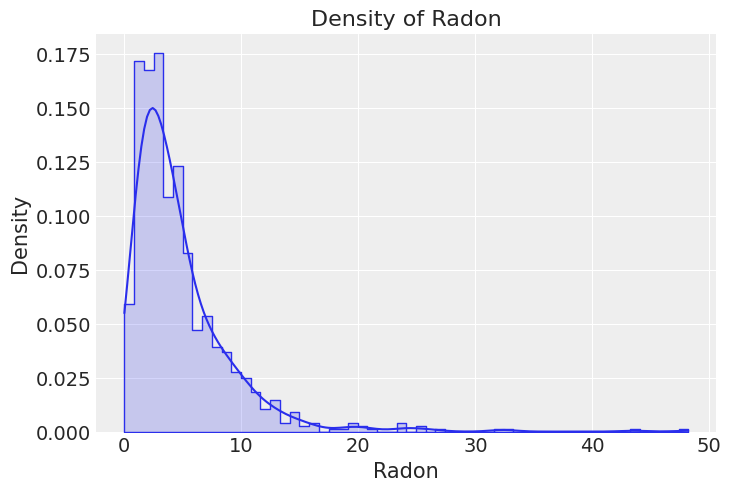

In [7]:
fig, ax = plt.subplots()
sns.histplot(x="activity", alpha=0.2, stat="density", element="step", common_norm=False, data=df, ax=ax)
sns.kdeplot(x="activity", data=df, ax=ax, cut=0)
ax.set(title="Density of Radon", xlabel="Radon", ylabel="Density");

Next, let us see the global `log(radon + 0.1)` distribution.

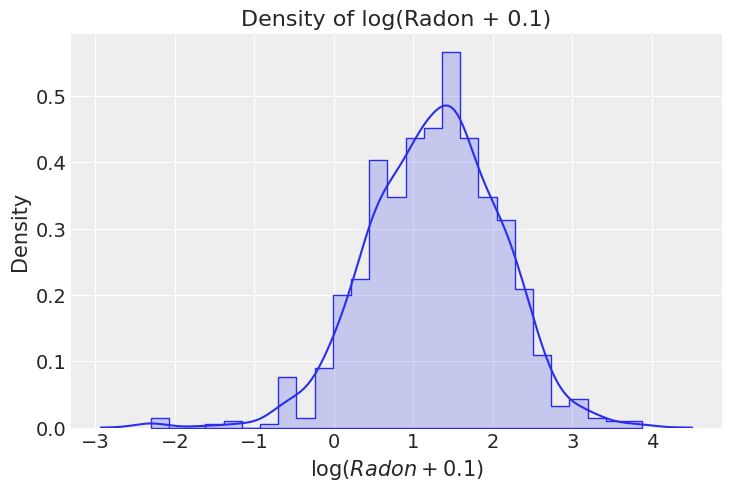

In [8]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", alpha=0.2, stat="density", element="step", common_norm=False, data=df, ax=ax)
sns.kdeplot(x="log_radon", data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log(Radon + 0.1)$", ylabel="Density");

There are many a priori reasons to think houses with basement has higher radon levels. From geochemistry to composition of building materials to poor ventilation. We can split the distribution of `log(radon + 0.1)` per `floor` to see if we are able to see that difference in our data.

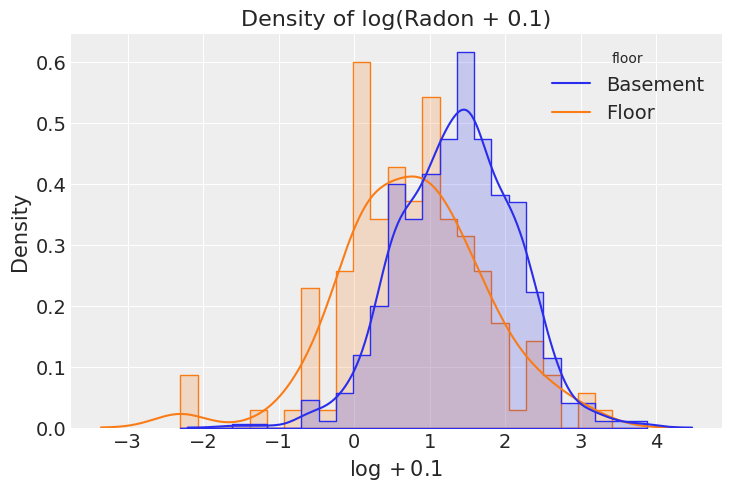

In [9]:
fig, ax = plt.subplots()
sns.histplot(
    x="log_radon", hue="floor", alpha=0.2, stat="density", element="step", 
    common_norm=False, data=df, ax=ax
)
sns.kdeplot(x="log_radon", hue="floor", common_norm=False, data=df, ax=ax)
ax.set(title="Density of log(Radon + 0.1)", xlabel="$\log + 0.1$", ylabel="Density");

This exploration tell us that, as expected, the average radon level is higher in `Basement` than `Floor`.

Next, we are going to count the number of counties.

In [10]:
n_counties = df["county"].unique().size
print(f"Number of counties: {n_counties}")

Number of counties: 85


Let us dig deeper into the distribution of radon and number of observations per county and floor level.

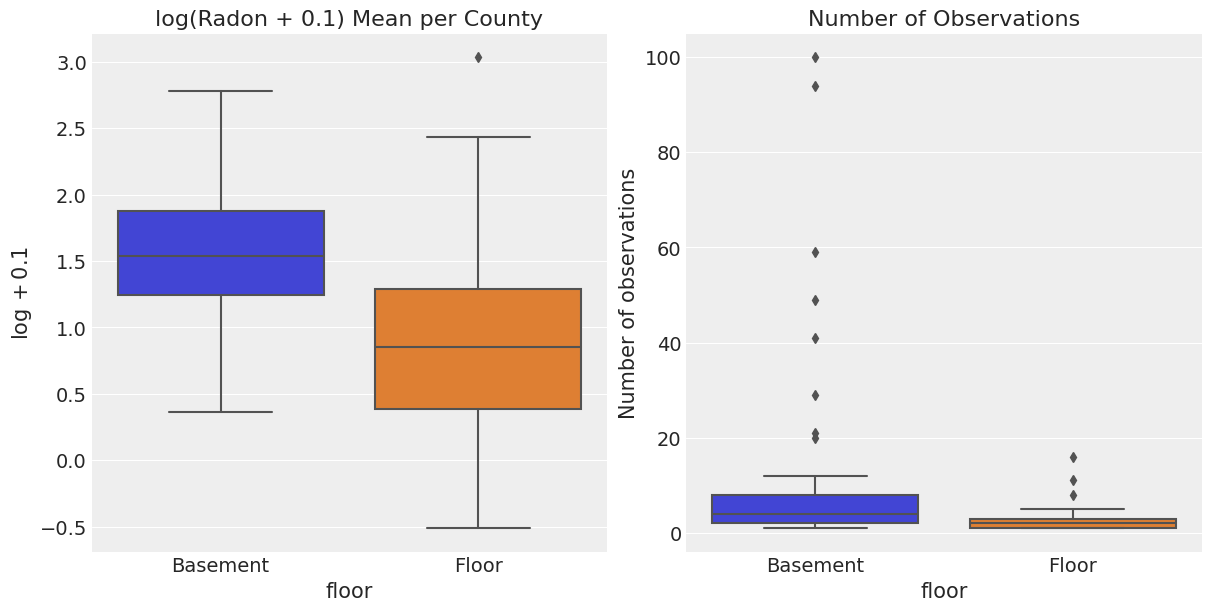

In [11]:
log_radon_county_agg  = (
    df 
    .groupby(["county", "floor"], as_index=False)
    .agg(
        log_radon_mean=("log_radon", "mean"),
        n_obs=("log_radon", "count")
    )
)

fig, ax= plt.subplots(nrows=1, ncols=2, figsize=(12, 6), layout="constrained")
sns.boxplot(x="floor", y="log_radon_mean", data=log_radon_county_agg, ax=ax[0])
ax[0].set(title="log(Radon + 0.1) Mean per County", ylabel="$\log + 0.1$")

sns.boxplot(x="floor", y="n_obs", data=log_radon_county_agg, ax=ax[1])
ax[1].set(title="Number of Observations", xlabel="floor", ylabel="Number of observations");

- On the left hand side we can see that the `"Basement"` distribution per county is shifted to higher values with respect to the `"Floor"` distribution. We had seen this above when considering all counties together.
- On the right hand side we see that the number of observations per county is not the same for the `floor` levels. In particular, we see that there are some counties with a lot of basement observations. This can create some bias when computing simple statistics to compare across counties. Moreover, not all `county` and `floor` combinations are present in the dataset. For example:

In [12]:
assert df.query("county == 'YELLOW MEDICINE' and floor == 'Floor'").empty

## Models: Conventional Approaches

### Complete Pooling

#### Model

For this first model we only consider the predictor `floor`, which represents the floor level. The following equation describes the linear model that we are going to build with Bambi

$$
y = \beta_{j} + \varepsilon
$$


where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement }\\
\beta_{j} &= \text{Coefficient for the floor level } j \\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

Each $j$ indexes a different floor level. In this case, $j=1$ means `"basement"` and $j=2$ means `"floor"`.

#### Priors

##### Common effects

The only common effect in this model is the floor effect represented by the $\beta_{j}$ coefficients. We have

$$
\beta_{j} \sim \text{Normal}(0, \sigma_{\beta_j})
$$

for $j: 1, 2$, where $\sigma_{\beta_j}$ is a positive constant that we set to 10 for all $j$.

##### Residual error

$$
\begin{aligned}
\varepsilon & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1. 

Let us now write the Bambi model.

The `0` on the right side of `~` in the model formula removes the global intercept that is added by default. This allows Bambi to use one coefficient for each floor level.

In [13]:
# A dictionary with the priors we pass to the model initialization
pooled_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

pooled_model = bmb.Model("log_radon ~ 0 + floor", df, priors=pooled_priors)
pooled_model

Formula: log_radon ~ 0 + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

The `Family name: Gaussian` indicates the selected family, which defaults to Gaussian. And `Link: identity` indicates the default value for the link argument in `bmb.Model()`. Taken together this simply means that we are fitting a normal linear regression model.

Let's see the graph representation of the model before fitting. To do so, we first need to call the `.build()` method. Internally, this builds the underlying PyMC model.

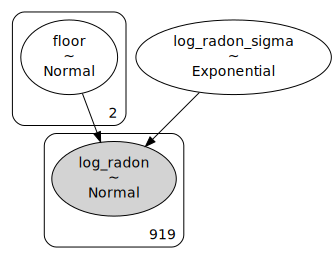

In [14]:
pooled_model.build()
pooled_model.graph()

Let's now fit the model.

In [15]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


Now we can examine the posterior distribution, i.e. the joint distribution of model parameters conditional on the data:

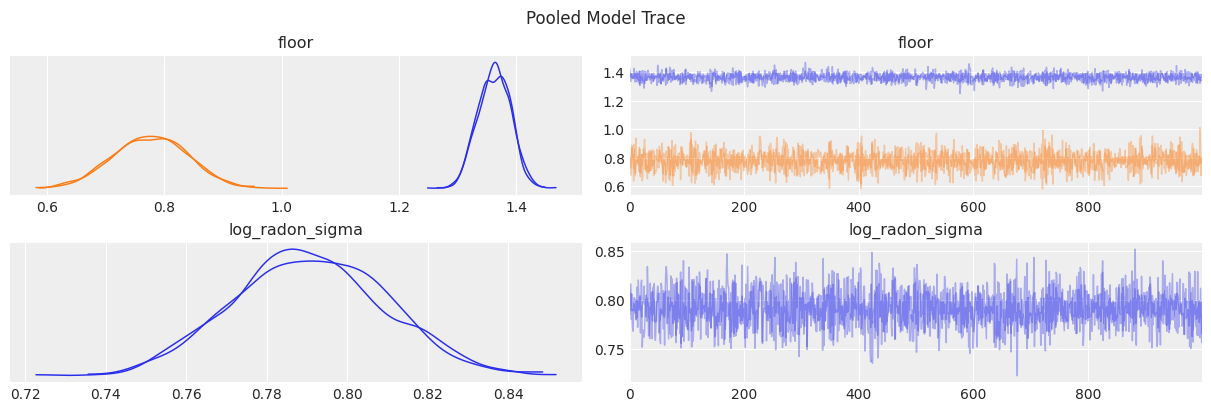

In [16]:
az.plot_trace(data=pooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Pooled Model Trace");

We can also see some posterior summary statistics.

In [17]:
pooled_summary = az.summary(data=pooled_results)
pooled_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
floor[Basement],1.362,0.028,1.307,1.409,0.001,0.000,2613.0,1627.0,1.0
floor[Floor],0.777,0.064,0.665,0.902,0.001,0.001,2986.0,1561.0,1.0
log_radon_sigma,0.791,0.019,0.757,0.827,0.000,0.000,2376.0,1493.0,1.0


From the posterior plot and the summary, we can see the mean radon level is considerably higher in the Basement than in the Floor level. This reflects what we originally saw in the initial data exploration. In addition, sice we have more measurements in the Basement, the uncertainty in its posterior is smaller than the uncertainty in the posterior for the Floor level.

We can compare the mean of the posterior distribution of the `floor` terms to the sample mean. This is going to be useful to understand the meaning of **complete pooling**.

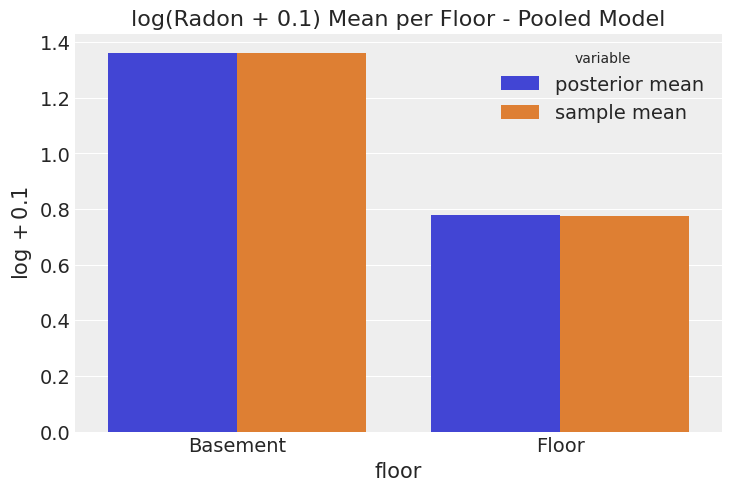

In [18]:
fig, ax = plt.subplots()

(
    pooled_summary["mean"]
    .iloc[:-1]
    .reset_index()
    .assign(floor = lambda x: x["index"].str.slice(6, -1).str.strip())
    .merge(
        right=df.groupby(["floor"])["log_radon"].mean(),
        left_on="floor",
        right_index=True
    )
    .rename(columns={
        "mean": "posterior mean",
        "log_radon": "sample mean"
    })
    .melt(
        id_vars="floor",
        value_vars=["posterior mean", "sample mean"]
    )
    .pipe((sns.barplot, "data"),
        x="floor",
        y="value",
        hue="variable",
        ax=ax
    )
)
ax.set(title="log(Radon + 0.1) Mean per Floor - Pooled Model", ylabel="$\log + 0.1$");

From the plot alone it is hard to detect the difference between the posterior mean and the sample mean. This happens because the estimation for any observation in either group is simply the group mean plus the smoothing due to the non-flat priors. 

In other words, for every observation where `floor` is `"Basement"` the model predicts the mean radon for all the basement measurements, and for every observation where `floor` is `"Floor"`, the model predicts the mean radon for all the floor measurements.

**What does _complete pooling_ exactly mean here?**

In this example, the pooling refers to how we treat the different counties when computing estimates (i.e. this does not refer to pooling across floor levels for example). _Complete pooling_ means that all measurements for all counties are pooled into a single estimate ("treat all counties the same"), conditional on the floor level (because it is used as a covariate/predictor). For that reason, when computing the prediction for a given observation, we do not discriminate which county it belongs to. We pool all the counties into a single estimate, or in other words, we perform a complete pooling.

Let's now compare the posterior predictive distribution for each group with the distribution of the observed data.

To do this we need to perform a couple of steps:

- Obtain samples from the posterior predictive distribution using the `.predict()` method.
- Apply the inverse transform to have the posterior predictive samples in the original scale of the response.

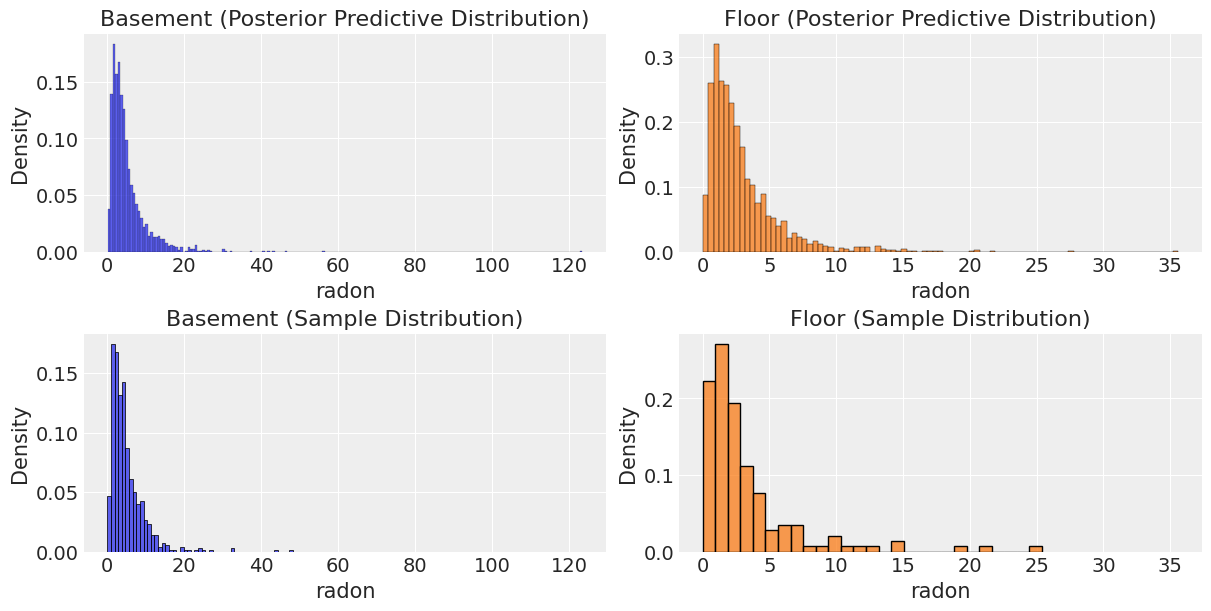

In [19]:
# Note we create a new data set. 
# One observation per group is enough to obtain posterior predictive samples for that group
# The more observations we create, the more posterior predictrive samples from the same distribution
# we obtain.
new_data = pd.DataFrame({"floor": ["Basement", "Floor"]})
pooled_model.predict(pooled_results, kind="pps", data=new_data)

# Stack chains and draws and extract posterior predictive samples
pps = pooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

# Inverse transform the posterior predictive samples
pps = np.exp(pps) - 0.1

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), layout="constrained")
ax = ax.flatten()

sns.histplot(x=pps[0].flatten(), stat="density", color="C0", ax=ax[0])
ax[0].set(title="Basement (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Basement'"), stat="density", ax=ax[2])
ax[2].set(title="Basement (Sample Distribution)", xlim=ax[0].get_xlim(), xlabel="radon", ylabel="Density")

sns.histplot(x=pps[1].flatten(), stat="density", color="C1", ax=ax[1])
ax[1].set(title="Floor (Posterior Predictive Distribution)", xlabel="radon", ylabel="Density")
sns.histplot(x="activity", data=df.query("floor == 'Floor'"), stat="density", color="C1", ax=ax[3])
ax[3].set(title="Floor (Sample Distribution)", xlim=ax[1].get_xlim(), xlabel="radon", ylabel="Density");

The distributions look very similar, but we see that we have some extreme values. Hence if we need a number to compare them let us use the median.

In [20]:
np.median(a=pps, axis=1)

array([3.83010025, 2.13711049])

In [21]:
df.groupby(["floor"])["activity"].median()

floor
Basement    3.9
Floor       2.1
Name: activity, dtype: float64

### No Pooling

The following model uses both `floor` and `county` as predictors. They are represented with an interaction effect. It means the predicted radon level for a given measurement depends both on the floor level as well as the county. This interaction coefficient allows the floor effect to vary across counties. Or said analogously, the county effect can vary across floor levels.

#### Model

$$
y = \gamma_{jk} + \varepsilon
$$

where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement }\\
\gamma_{jk} &= \text{Coefficient for floor level } j \text{ and county } k\\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The common effect is the interaction between `floor` and `county`. The prior is

$$
\gamma_{jk} \sim \text{Normal}(0, \sigma_{\gamma_{jk}})
$$

for all $j: 1, 2$ and $k: 1, \cdots, 85$.  
$\sigma_{\gamma_{jk}}$ is a positive constant that we set to 10 in all cases.

##### Residual error

$$
\begin{aligned}
\varepsilon_i & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$
where $\lambda$ is a positive constant that we set to 1.

To specify this model in Bambi we can use the formula `log_radon ~ 0 + county:floor`. Again, we remove the global intercept with the `0` on the right hand side. `county:floor` specifies the multiplicative interaction between `county` and `floor`.

In [22]:
unpooled_priors = {
    "county:floor": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("Exponential", lam=1),
}

unpooled_model = bmb.Model("log_radon ~ 0 + county:floor", df, priors=unpooled_priors)
unpooled_model

Formula: log_radon ~ 0 + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county:floor ~ Normal(mu: 0, sigma: 10)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [23]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, county:floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 48 seconds.


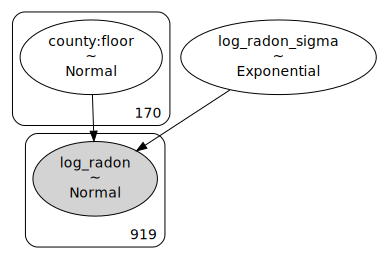

In [24]:
unpooled_model.graph()

From the graph representation of the model we see the model estimates $170 = 85 \times 2$ parameters for the `county:floor` interaction. Let us now explore the model fit.

First, we can now see the plot of the marginal posterior distributions along with the sampling traces.

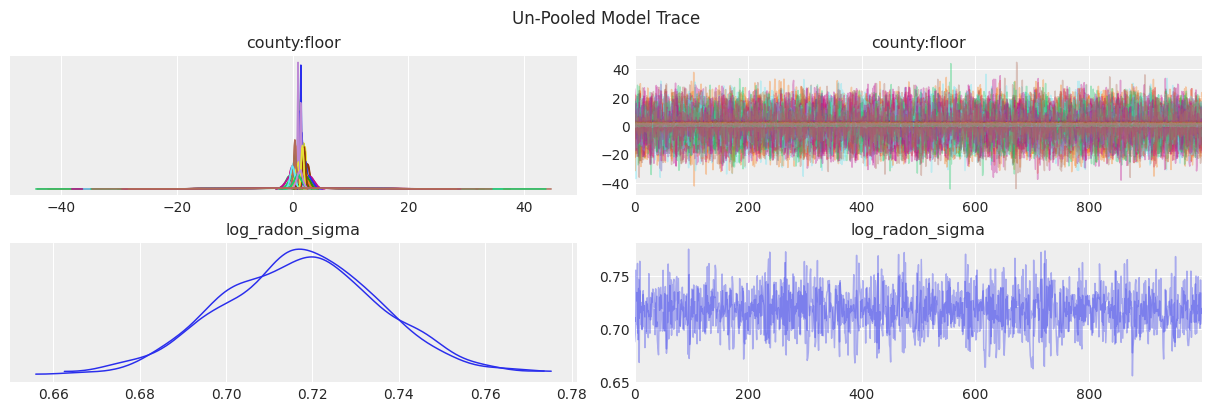

In [25]:
az.plot_trace(data=unpooled_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Un-Pooled Model Trace");

Some posteriors for `county:floor` are much more spread than others, which makes it harder to compare them. To obtain a better summary visualization we can use a forest plot. This plot also allows us to identify exactly the combination of `county` and `floor` level.

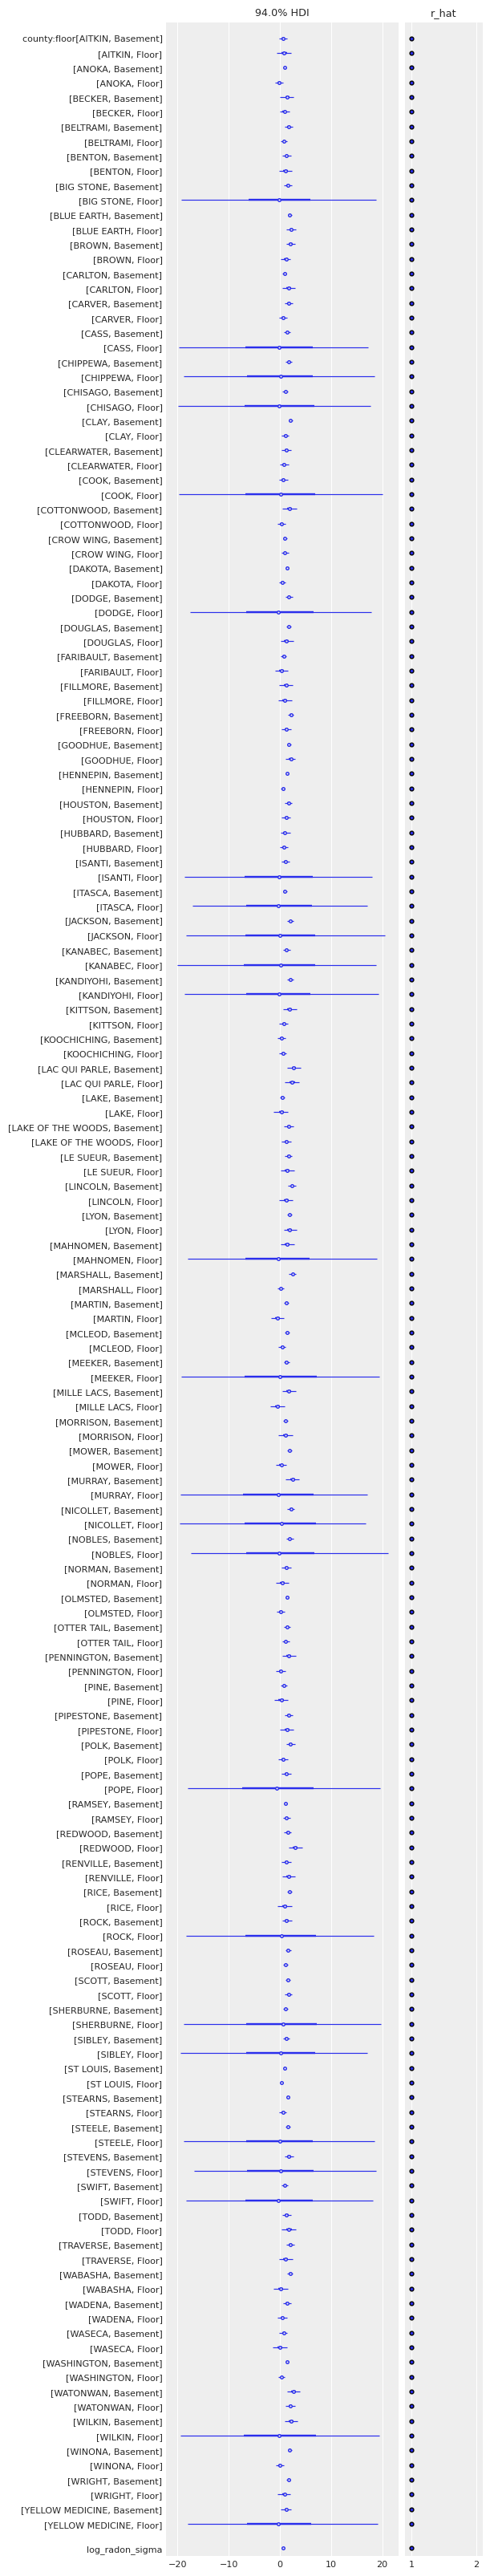

In [26]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

Note how for the combination `county == 'YELLOW MEDICINE' and floor == 'Floor'` where we do not have any observations, the model can still generate predictions which are essentially coming from the prior distributions, which explains the large HDI intervals.

Next, let's have a look into the posterior mean for each `county` and `floor` combination:

In [27]:
unpooled_summary = az.summary(data=unpooled_results)

We can now plot the posterior distribution mean of the gamma coefficients against the observed values (sample).

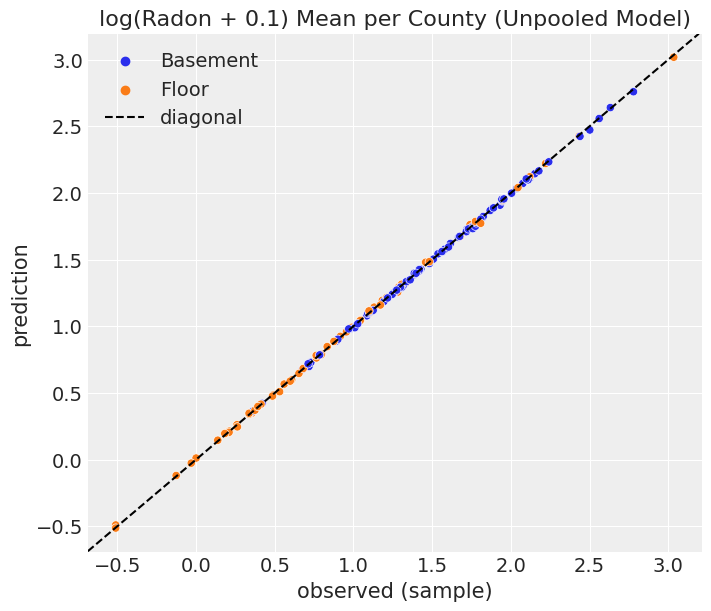

In [28]:
# Get county and floor names from summary table
var_mapping = (
    unpooled_summary
    .iloc[:-1]
    .reset_index(drop=False)["index"].str.slice(13, -1).str.split(",").apply(pd.Series)
)

var_mapping.rename(columns={0: "county", 1: "floor"}, inplace=True)
var_mapping["county"] = var_mapping["county"].str.strip()
var_mapping["floor"] = var_mapping["floor"].str.strip()
var_mapping.index = unpooled_summary.iloc[:-1].index
    
# Merge with observed values
unpooled_summary_2 = pd.concat([var_mapping, unpooled_summary.iloc[:-1]], axis=1)

fig, ax = plt.subplots(figsize=(7, 6))

(
    unpooled_summary_2
    .merge(right=log_radon_county_agg, on=["county", "floor"], how="left")
    .pipe(
        (sns.scatterplot, "data"),
        x="log_radon_mean",
        y="mean",
        hue="floor",
        ax=ax
    )
)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(
    title="log(Radon + 0.1) Mean per County (Unpooled Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
);

As expeced, the values strongly concentrated along the diagonal. In other words, for each county and floor level combination, the model uses their sample mean of radon level as prediction, plus smoothing due to the non-flat priors.

**What does _no pooling_ exactly mean here?**

In the previous example we said _complete pooling_ means the observations are pooled together into single estimates no matter the county they belong to. The situation is completely the opposite in this _no pooling_ scenario. Here, none of the measurements in a given county affect the computation of the coefficient for another county. That's why, in the end, the estimation for each combination of county and floor level (i.e. $\gamma_{jk}$) is the mean of the measurements in that county and floor level (plus prior smoothing) as is reflected in the diagonal scatterplot above.

## Multilevel and hierarchical models

In this section we are going to explore various types of hierarchical models. If you're familiar with the PyMC way of using hierarchies, the Bambi way (borrowed from mixed effects models way) may be a bit unfamiliar in the beginning, but as we will see, the notation is very convenient. A good explanation is found in [Chapter 16 from Bayes Rules book](https://www.bayesrulesbook.com/chapter-16.html), specifically [section 16.3.2](https://www.bayesrulesbook.com/chapter-16.html#another-way-to-think-about-it). Moreover, you can also take a look into the [Bambi examples section](https://bambinos.github.io/bambi/main/examples.html) where you can find other use cases.

### Partial pooling model

We start with a model that considers a global intercept and varying intercepts for each county. The dispersion parameter of the prior for these varying intercepts is an _hyperprior_ that is common to all the counties. As we are going to conclude later, this is what causes the **partial pooling** in the model estimates.


#### Model

Let us use greek letters for common effects and roman letters for varying effects. In this case, $\alpha$ is a common intercept and $u$ is a group-specific intercept. 

$$
y = \alpha + u_j + \varepsilon
$$

where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement } \\
\alpha &= \text{Intercept common to all measurements or global intercept} \\
u_j &= \text{Intercept specific to the county } j \\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The only common effect in this model is the intercept $\alpha$. We have

$$
\alpha \sim \text{Normal}(0, \sigma_\alpha)
$$

where $\sigma_\alpha$ is a positive constant that we set to 10.

##### Group-specific effects

$$
u_j \sim \text{Normal}(0, \sigma_u)
$$

for all $j: 1, \cdots, 85$.  

Contrary to the common effects case, $\sigma_u$ is considered a random variable. 

We assign $\sigma_u$ the following hyperprior, which is the same to all the counties,

$$
\sigma_u\sim \text{Exponential}(\tau)
$$

and $\tau$ is a positive constant that we set to $1$.

##### Residual error

$$
\begin{aligned}
\varepsilon & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

#### Notes

The common intercept $\alpha$ represents the mean response across all counties and floor levels. 

On top of it, the county-specific intercept terms $u_j$ represent county-specific deviations from that global mean. This type of term is also known as a vaying intercept in the statistical literature.

In [29]:
# We can add the hyper-priors inside the prior dictionary parameter of the model constructor
partial_pooling_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

partial_pooling_model = bmb.Model(
    formula="log_radon ~ 1 + (1|county)", 
    data=df, 
    priors=partial_pooling_priors, 
    noncentered=False
)
partial_pooling_model

Formula: log_radon ~ 1 + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

The `noncentered` argument asks Bambi not to use the non centered representation for the varying effects. This makes the graph representation clearer and is closer to the original implementation in the PyMC documentation.

In [30]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


We can inspect the graphical representation of the model:

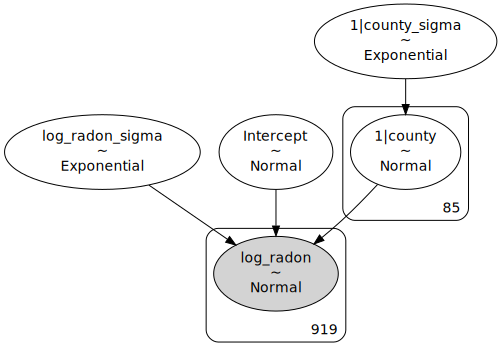

In [31]:
partial_pooling_model.graph()

We can clearly see a new hierarchical level as compared to the complete pooling model and unpooled model.

Next, we can plot the posterior distribution of the coefficients in the model:

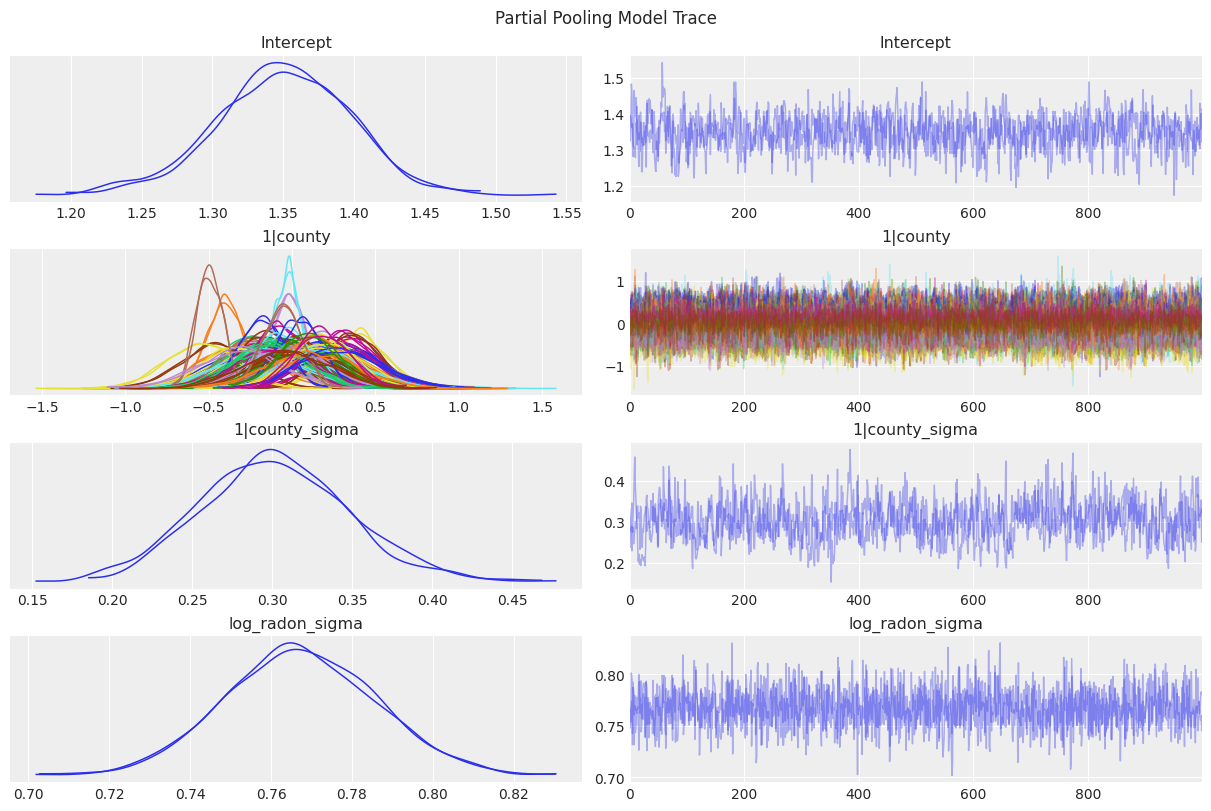

In [32]:
az.plot_trace(data=partial_pooling_results, compact=True, chain_prop={"ls": "-"})
plt.suptitle("Partial Pooling Model Trace");

* `1|county` is $u_j$, the county-specific intercepts.
* `1|county_sigma` is $\sigma_u$, the standard deviation of the county-specific intercepts above.

Let us now compare the posterior predictive mean against the observed data at county level.

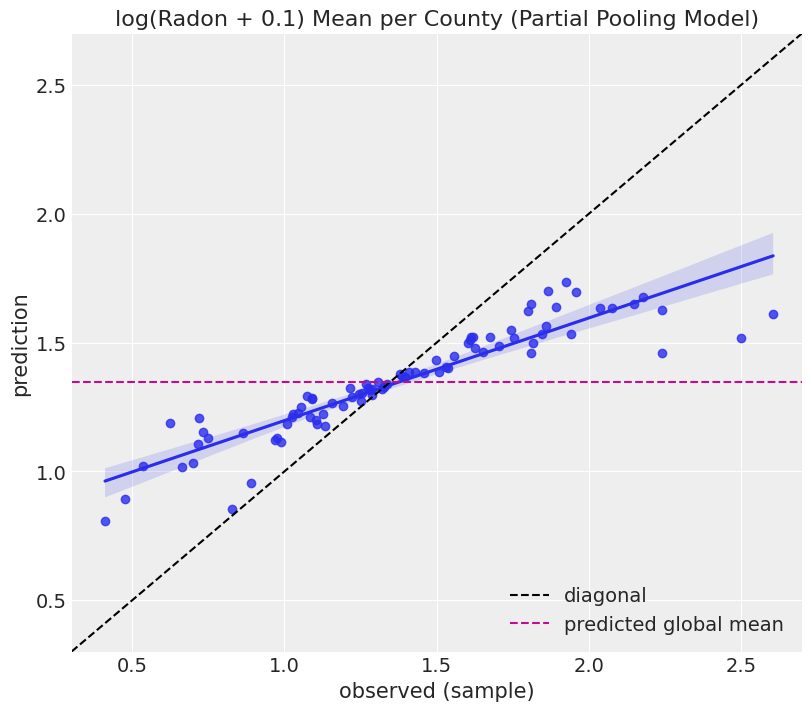

In [33]:
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# Stack chains and draws. pps stands for posterior predictive samples
pps = partial_pooling_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

pps_df = pd.DataFrame(data=pps).assign(county=df["county"])
y_pred = pps_df.groupby("county").mean().mean(axis=1)
y_sample = df.groupby("county")["log_radon"].mean()

fig, ax = plt.subplots(figsize=(8, 7))
sns.regplot(x=y_sample, y=y_pred, ax=ax)
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(y=y_pred.mean(), color="C3", linestyle="--", label="predicted global mean")
ax.legend(loc="lower right")
ax.set(
    title="log(Radon + 0.1) Mean per County (Partial Pooling Model)",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.3, 2.7),
    ylim=(0.3, 2.7),
);

Note that in this case the points are not concentrated along the diagonal (as it was the case for the unpooled model). The reason is that in the partial pooling model the hyperprior shrinks the predictions towards the global mean, represented by the horizonital dashed line.

**What does _partial pooling_ exactly mean here?**

We said the first model we built performed a **complete pooling** because estimates pooled observations regardless to which county they belong to. We could see that in the coefficients for the `floor` variable. The estimate for each level was the sample mean for each level, plus prior smoothing, without making any special distinction to observations from different counties.

Then, when we built our second model we said it performed **no pooling**. This was the opposite scenario. Estimates for effects involving a specific county were not informed at all by the information in the other counties.

Now, we say this model performs **partial pooling**. But what does it mean? Well, if we had **complete** pooling and **no** pooling, this must be some type of compromise in between.

In this model, we have a global intercept $\alpha$, which represents the mean of the response variable across all counties. We also have group-specific intercepts $u_j$ that represent deviations from the global mean specific to each county $j$. Thess group-specific intercepts are assigned a Normal prior centered at 0. The standard deviations of these priors are considered random, instead of fixed. Since they are random, they are assigned a prior distribution, which is a hyperprior in this case because it is a prior on top of a prior. And that hyperprior is the same distribution for all the county-specific intercepts. Because of that, these random deviations from the global mean are not independent. Indeed, the shared hyperprior is what causes the **partial pooling** in the model estimates. In other words, some information is shared between counties when computing estimates for their effects and it results in a shrinkage towards the global mean.

Connecting what we've just said with the figure above we can see the **partial pooling is a compromise between complete pooling (global mean) and no pooling (diagonal)**.

### County-specific intercepts and common predictors 

Next, we add the `floor` global feature (i.e. does not depend on the `county`) into the model above. We remove the global intercept so Bambi keeps one coefficient for each `floor` level. 

In the original PyMC example, this model is introduced under the [Varying intercept model](https://docs.pymc.io/projects/examples/en/latest/case_studies/multilevel_modeling.html#varying-intercept-model) title. We feel that "County-specific intercepts and common predictors" is a more accurate representation of the model we build in Bambi. It is correct to say this is a varying intercept model, because of the county-specific intercepts, but so was the last model we built.

#### Model

$$
y = \beta_j + u_k + \varepsilon
$$

where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement } \\
\beta_j &= \text{Coefficient for the floor level } j \\
u_k &= \text{Intercept specific to the county } k \\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The common effect in this model is the floor term $\beta_j$

$$
\beta_j \sim \text{Normal}(0, \sigma_{\beta_j})
$$

for all $j: 1, 2$ and $\sigma_{\beta_j}$ is a positive constant that we set to $10$.

##### Group-specific effects
 
$$
u_k \sim \text{Normal}(0, \sigma_u)
$$

for all $j:1, \cdots, 85$. The hyperprior is 

$$

\sigma_u \sim \text{Exponential}(\tau)

$$

and $\tau$ is a positive constant that we set to $1$.

##### Residual error

$$
\begin{aligned}
\varepsilon & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to $1$.

##### Notes

$\beta_j$ and $u_k$ may look similar. The difference is that the latter is a hierarchical effect (it has a hyperprior), while the former is not.

In [34]:
varying_intercept_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "1|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

varying_intercept_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (1|county)",
    data=df,
    priors=varying_intercept_priors,
    noncentered=False
 )

varying_intercept_model

Formula: log_radon ~ 0 + floor + (1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    1|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [35]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, 1|county, 1|county_sigma, floor]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


When looking at the graph representation of the model we still see the hierarchical structure for the `county` varying intercepts, but we do not see it for the `floor` feature as expected.

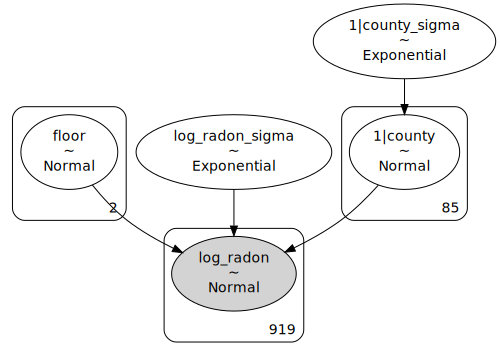

In [36]:
varying_intercept_model.graph()

Let us visualize the posterior distributions:

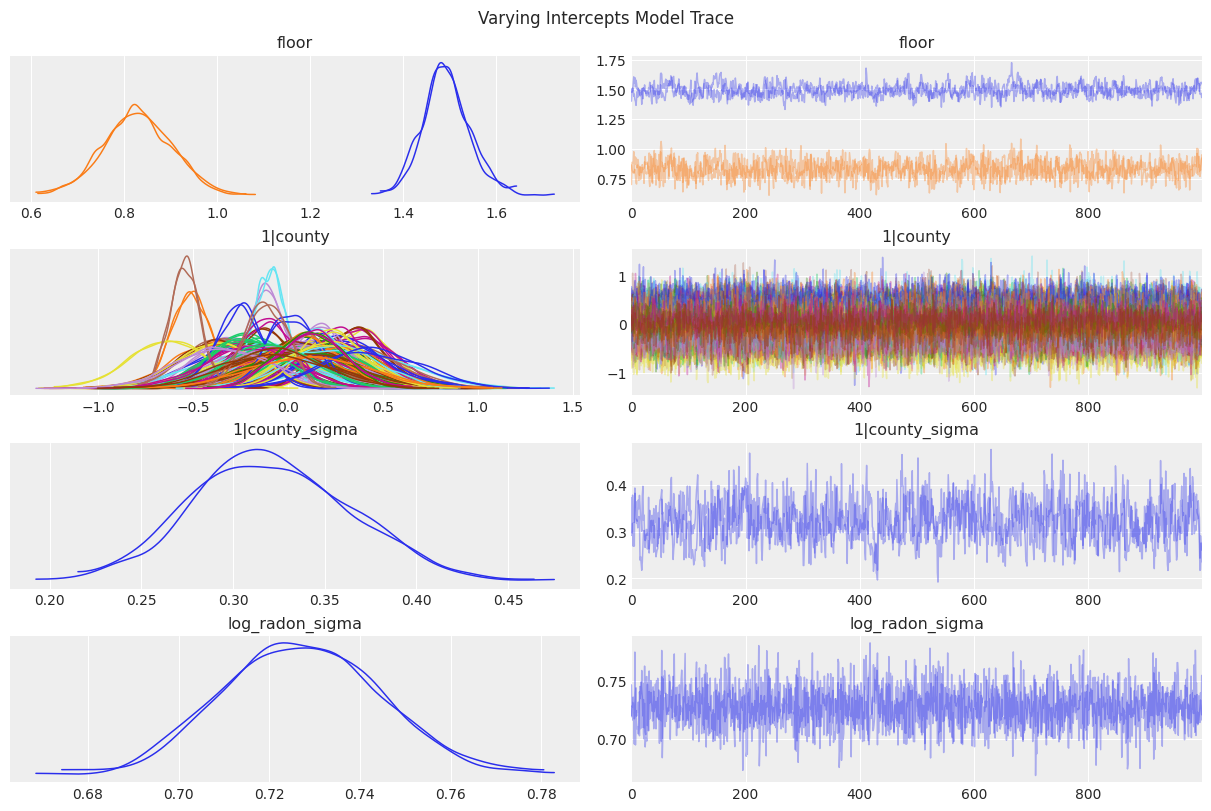

In [37]:
az.plot_trace(data=varying_intercept_results, compact=True, chain_prop={"ls": "-"});
plt.suptitle("Varying Intercepts Model Trace");

### Varying intercept and slope model

Next we want to include a hierarchical structure in the floor effect.

#### Model

$$
y = \beta_j + b_{jk} + \varepsilon
$$

where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement}\\
\beta_j &= \text{Coefficient for the floor level } j \\
b_{jk} &= \text{Coefficient for the floor level } j \text{ specific to the county } k\\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

The common effect in this model is the floor term $\beta_j$

$$
\beta_j \sim \text{Normal}(0, \sigma_{\beta_j})
$$

where $\sigma_{\beta_j}$ is a positive constant that we set to $10$.

##### Group-specific effects

Here, again, we have the floor effects 

$$
b_{jk} \sim \text{Normal}(0, \sigma_{b_j})
$$

for $j:1, 2$ and $k: 1, \cdots, 85$. 

The hyperprior is 

$$
\sigma_{b_j} \sim \text{Exponential}(\tau)
$$

for $j:1, 2$.

$\tau$ is a positive constant that we set to $1$.

##### Residual error

$$
\begin{aligned}
\varepsilon & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to 1.

##### Notes

Both $\beta_j$ and $b_{jk}$ are floor effects. The difference is that the first one is a common effect, while the second is a group-specific effect. In other words, the second floor effect varies from county to county. These effects represent the county specific deviations from the common floor effect $\beta_j$. Because of the hyperprior, the $b_{jk}$ effects aren't independent and result in the partial-pooling effect.

In this case the Bambi model specification is quite easy, namely `log_radon ~ 0 + floor + (0 + floor|county)`. This formula represents the following terms:

 - The first `0` tells we don't want a global intercept.
 - `floor` is $\beta_j$. It says we want to include an effect for each floor level. Since there's no global intercept, a coefficient for each level is included.
 - The `0` in `(0 + floor|county)` means we don't want county-specific intercept. We need to explicitly turn it off as we did with the regular intercept.
 - `floor|county` is $b_{jk}$,  the county-specific floor coefficients. Again, since there's no varying intercepot for the counties, this includes coefficients for both floor levels.

In [38]:
varying_intercept_slope_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

varying_intercept_slope_model = bmb.Model(
    formula="log_radon ~ 0 + floor + (0 + floor|county)",
    data=df,
    priors=varying_intercept_slope_priors,
    noncentered=True
 )

varying_intercept_slope_model

Formula: log_radon ~ 0 + floor + (0 + floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    floor|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

Next, we fit the model. Note we increase the default number of `draws` from the posterior and the `tune` samples to 2000. In addition, as the structure of the model gets more complex, so does the posterior. That's why we increase `target_accept` from the default 0.8 to 0.9, because we want to explore the posterior more cautiously .

In [39]:
varying_intercept_slope_results = varying_intercept_slope_model.fit(
    draws=2000, 
    tune=2000,
    target_accept=0.9
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county_offset, floor|county_sigma, floor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In the graph representation of the model we can now see hierarchical structures both in the intercepts and the slopes. The terms that end with `_offset` appeared because we are using a non-centered parametrization. This parametrization is an algebraic trick that helps computation but leaves the model unchanged.

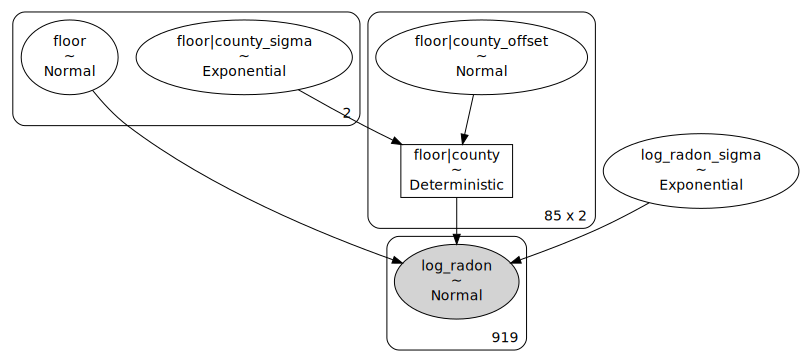

In [40]:
varying_intercept_slope_model.graph()

Let's have a look at the marginal posterior for the coefficients in the model.

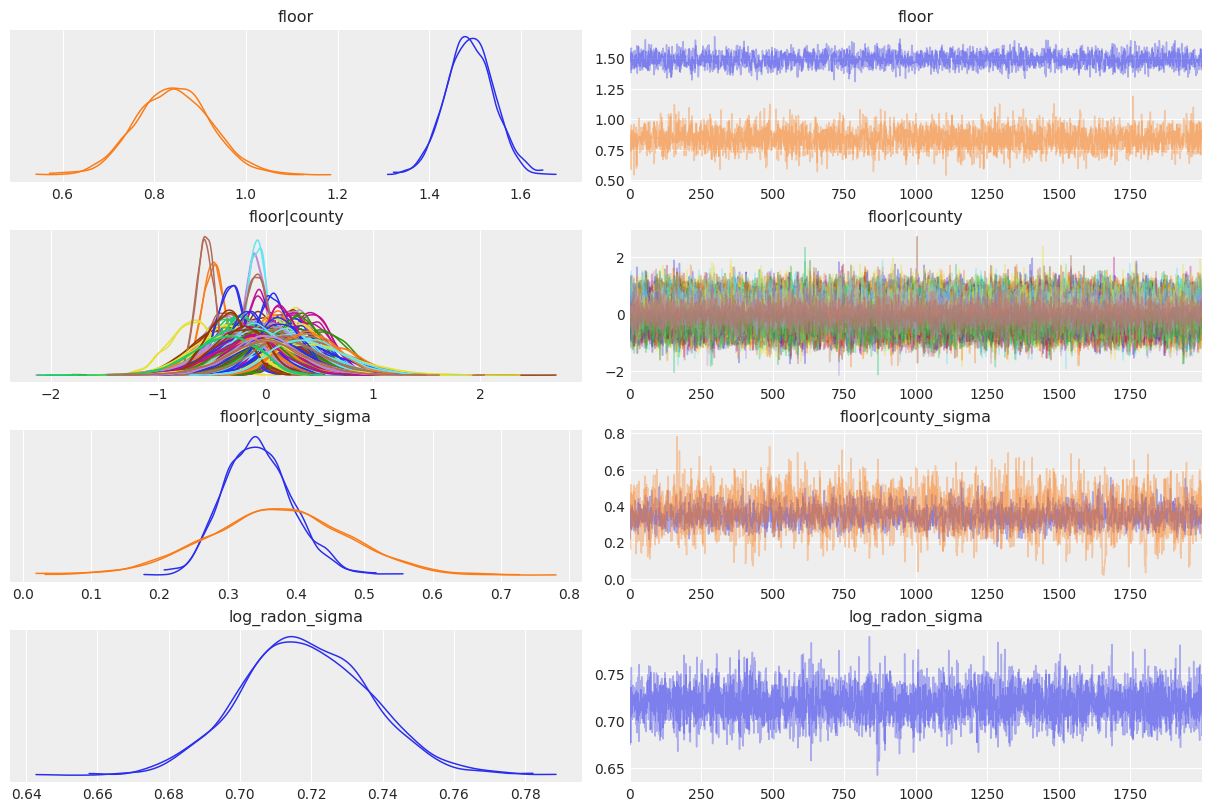

In [41]:
var_names = ["floor", "floor|county", "floor|county_sigma", "log_radon_sigma"]
az.plot_trace(
    data=varying_intercept_slope_results,
    var_names=var_names, 
    compact=True, 
    chain_prop={"ls": "-"}
);

### Adding group-level predictors

We now want to consider a county-level predictor, namely the (log) uranium level. This is not a county-level predictor in the sense that we use a county-specific coefficient, but in the sense that all the uranium concentrations were measured per county. Thus all the houses in the same county have the same uranium level.

#### Model


$$
y = \beta_j + \xi x + b_{jk} + \varepsilon
$$

where

$$
\begin{aligned}
y &= \text{Response for the (log) radon measurement} \\
x &= \text{Log uranium concentration} \\
\beta_j &= \text{Coefficient for the floor level } j \\
\xi &= \text{Coefficient for the slope of the log uranium concentration}\\
b_{jk} &= \text{Coefficient for the floor level } j \text{ specific to the county } k\\
\varepsilon & = \text{Residual random error}
\end{aligned}
$$

#### Priors

##### Common effects

This model has two common effects:

$$
\begin{aligned}
\beta_j \sim \text{Normal}(0, \sigma_{\beta_j}) \\
\xi \sim \text{Normal}(0, \sigma_\xi)
\end{aligned}
$$

where $j:1, 2$ and all $\sigma_{\beta_j}$ and $\sigma_{\xi}$ are set to $10$.

##### Group-specific effects

Here, again, we have the floor effects 

$$
b_{jk} \sim \text{Normal}(0, \sigma_{b_j})
$$

for $j:1, 2$ and $k: 1, \cdots, 85$. 

The hyperprior is 

$$
\sigma_{b_j} \sim \text{Exponential}(\tau)
$$

for $j:1, 2$.

$\tau$ is a positive constant that we set to $1$.

##### Residual error

$$
\begin{aligned}
\varepsilon & \sim \text{Normal}(0, \sigma) \\
\sigma & \sim \text{Exponential}(\lambda)
\end{aligned}
$$

where $\lambda$ is a positive constant that we set to $1$.

In [42]:
covariate_priors = {
    "floor": bmb.Prior("Normal", mu=0, sigma=10),
    "log_u": bmb.Prior("Normal", mu=0, sigma=10),
    "floor|county": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
    "sigma": bmb.Prior("Exponential", lam=1),
}

covariate_model = bmb.Model(
    formula="log_radon ~ 0 + floor + log_u + (0 + floor|county)",
    data=df,
    priors=covariate_priors,
    noncentered=True
 )

covariate_model

Formula: log_radon ~ 0 + floor + log_u + (0 + floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0, sigma: 10)
    log_u ~ Normal(mu: 0, sigma: 10)

  Group-level effects
    floor|county ~ Normal(mu: 0, sigma: Exponential(lam: 1))

  Auxiliary parameters
    sigma ~ Exponential(lam: 1)

In [43]:
covariate_results = covariate_model.fit(
    draws=2000, 
    tune=2000,
    target_accept=0.9
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_radon_sigma, floor|county_offset, floor|county_sigma, log_u, floor]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.


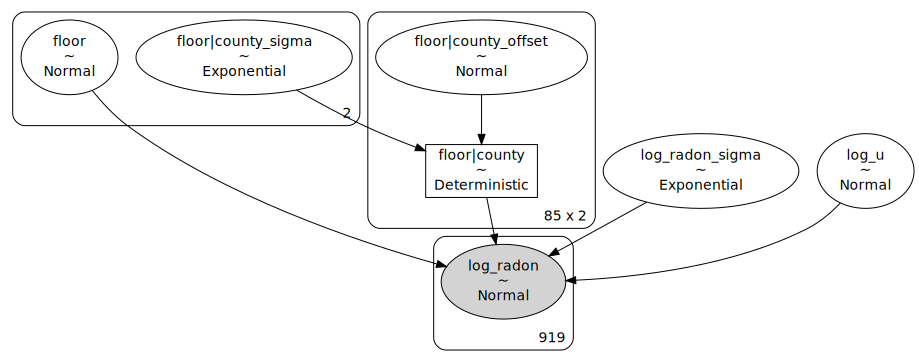

In [44]:
covariate_model.graph()

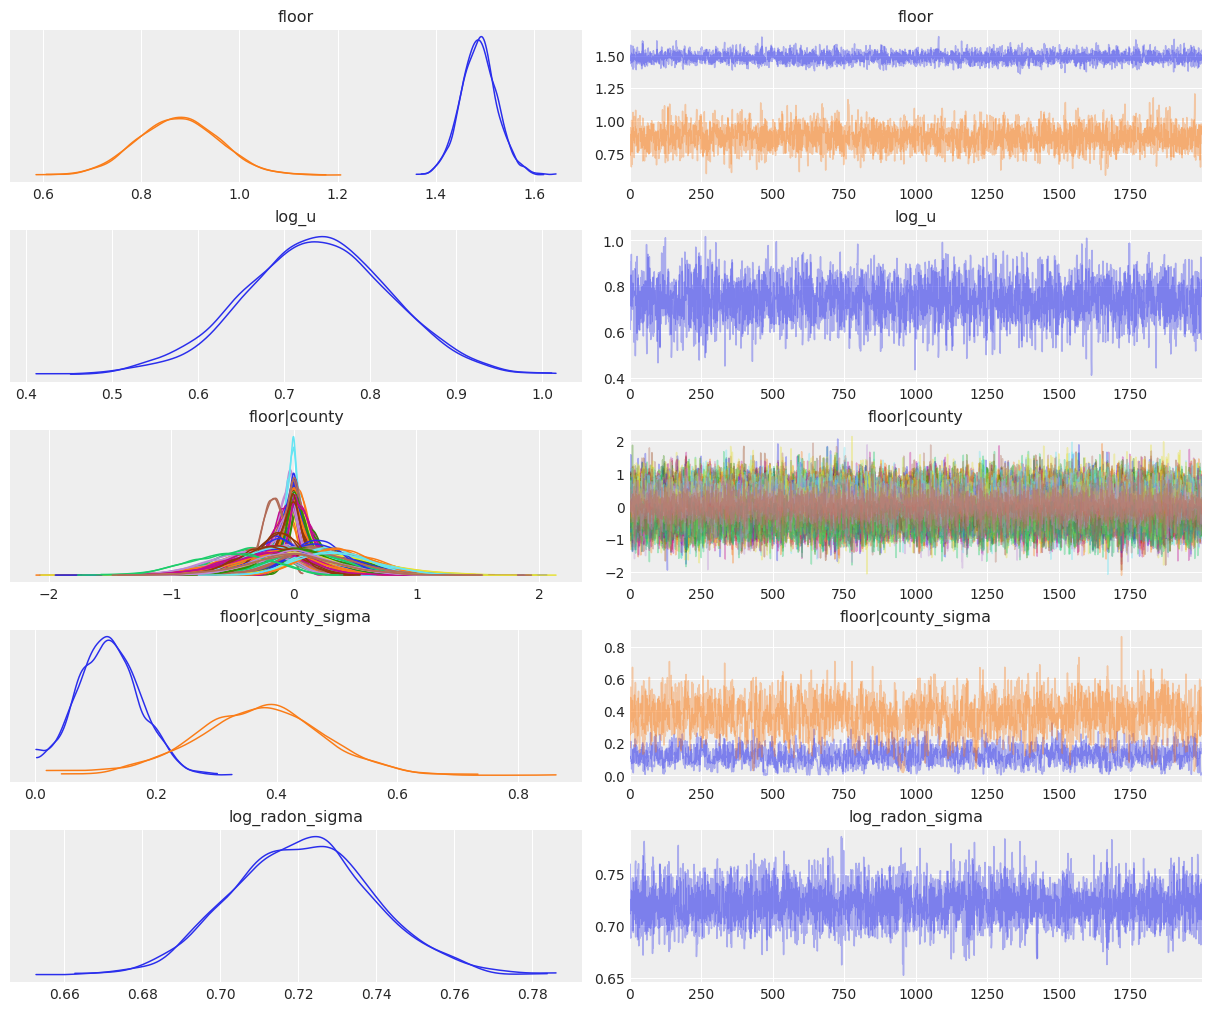

In [45]:
var_names = ["floor", "log_u", "floor|county", "floor|county_sigma", "log_radon_sigma"]
az.plot_trace(
    data=covariate_results,
    var_names=var_names, 
    compact=True, 
    chain_prop={"ls": "-"}
);

Let us now visualize the posterior distributions of the intercepts:

In [46]:
# get log_u values per county
log_u_sample = df.groupby(["county"])["log_u"].mean().values

# compute the slope posterior samples
log_u_slope = covariate_results.posterior["log_u"].values[..., None] * log_u_sample

# Compute the posterior for the floor coefficient when it is Basement
intercepts = (
    covariate_results.posterior.sel(floor_coord="Basement")["floor"]
    + covariate_results.posterior.sel(floor_coord_group_expr="Basement")["floor|county"] 
).values

y_predicted = (intercepts + log_u_slope).reshape(4000, n_counties).T

# reduce the intercepts posterior samples to the mean per county
mean_intercept = intercepts.mean(axis=2)[..., None] + log_u_slope

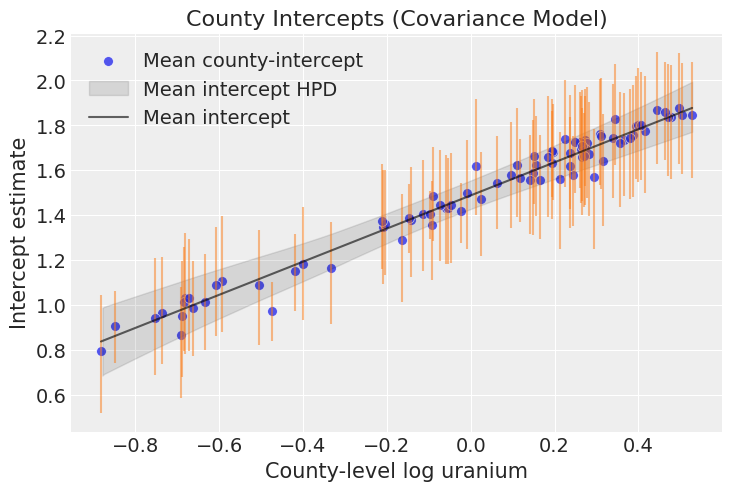

In [47]:
fig, ax = plt.subplots()

y_predicted_bounds = np.quantile(y_predicted, q=[0.03, 0.96], axis=1)

sns.scatterplot(
    x=log_u_sample,
    y=y_predicted.mean(axis=1),
    alpha=0.8,
    color="C0",
    s=50,
    label="Mean county-intercept",
    ax=ax
)
ax.vlines(log_u_sample, y_predicted_bounds[0], y_predicted_bounds[1], color="C1", alpha=0.5)

az.plot_hdi(
    x=log_u_sample,
    y=mean_intercept,
    color="black",
    fill_kwargs={"alpha": 0.1, "label": "Mean intercept HPD"},
    ax=ax
)

sns.lineplot(
    x=log_u_sample,
    y=mean_intercept.reshape(4000, n_counties).mean(axis=0),
    color="black",
    alpha=0.6,
    label="Mean intercept",
    ax=ax
)

ax.legend(loc="upper left")
ax.set(
    title="County Intercepts (Covariance Model)",
    xlabel="County-level log uranium",
    ylabel="Intercept estimate"
);

--- 

## Summary 

Let us dig deeper into the model comparison for the pooled, unpooled, and partial pooling models. To do so we are generate predictions for each model ad county level, where we aggregate by taking the mean, and plot them against the observed values.

In [48]:
# generate posterior predictive samples
pooled_model.predict(pooled_results, kind="pps")
unpooled_model.predict(unpooled_results, kind="pps")
partial_pooling_model.predict(partial_pooling_results, kind="pps")

# stack chain and draw values
pooled_pps = pooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values
unpooled_pps = unpooled_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values
partial_pooling_pps = partial_pooling_results.posterior_predictive.stack(sample=("chain", "draw"))["log_radon"].values

# Generate predictions per county
pooled_pps_df = pd.DataFrame(data=pooled_pps).assign(county=df["county"])
y_pred_pooled = pooled_pps_df.groupby("county").mean().mean(axis=1)

unpooled_pps_df = pd.DataFrame(data=unpooled_pps).assign(county=df["county"])
y_pred_unpooled = unpooled_pps_df.groupby("county").mean().mean(axis=1)

partial_pooling_pps_df = pd.DataFrame(data=partial_pooling_pps).assign(county=df["county"])
y_pred_partial_pooling = partial_pooling_pps_df.groupby("county").mean().mean(axis=1)

# observed values
y_sample = df.groupby("county")["log_radon"].mean()

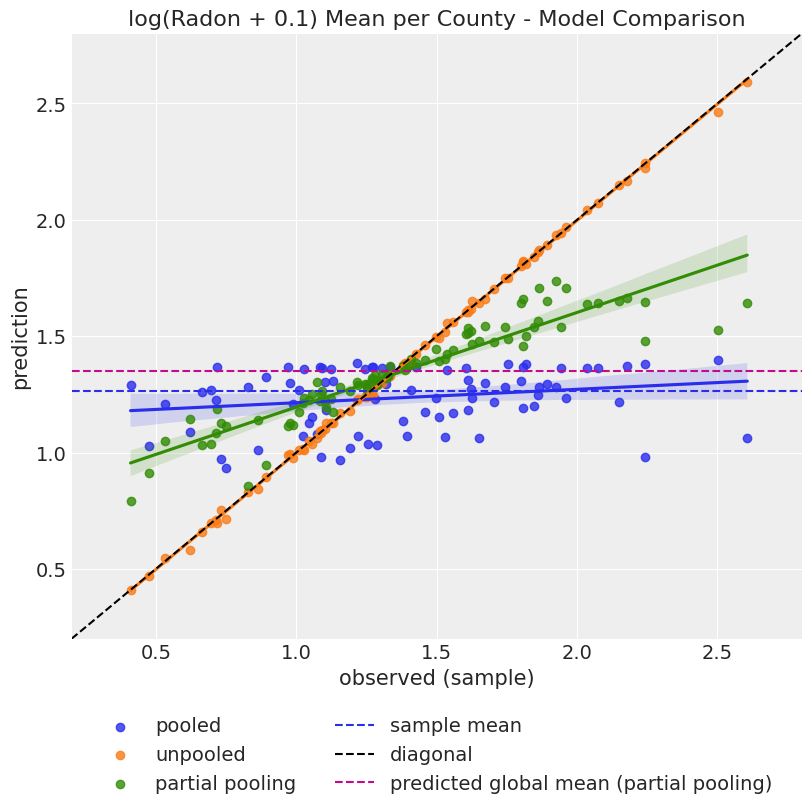

In [49]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.regplot(x=y_sample, y=y_pred_pooled, label="pooled", color="C0", ax=ax)
sns.regplot(x=y_sample, y=y_pred_unpooled, label="unpooled", color="C1", ax=ax)
sns.regplot(x=y_sample, y=y_pred_partial_pooling, label="partial pooling", color="C2", ax=ax)
ax.axhline(y=df["log_radon"].mean(), color="C0", linestyle="--", label="sample mean")
ax.axline(xy1=(1, 1), slope=1, color="black", linestyle="--", label="diagonal")
ax.axhline(
    y=y_pred_partial_pooling.mean(), color="C3",
    linestyle="--", label="predicted global mean (partial pooling)"
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)
ax.set(
    title="log(Radon + 0.1) Mean per County - Model Comparison",
    xlabel="observed (sample)",
    ylabel="prediction",
    xlim=(0.2, 2.8),
    ylim=(0.2, 2.8),
);

- The pooled model consider all the counties together, this explains why the predictions do not vary at county level. This is represented by the almost-flat line in the plot above (blue).
- On the other hand, the unpooled model considers each county separately, so the prediction is very close to the observation mean. This is represented by the line very close to the diagonal (orange).
- The partial pooling model is mixing global and information at county level. This is clearly seen by how corresponding (green) line is in between the pooling and unpooling lines. 

In [50]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Feb 12 2022

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.29.0

pandas    : 1.3.1
pymc3     : 3.11.4
arviz     : 0.11.4
seaborn   : 0.11.0
bambi     : 0.7.1
sys       : 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
numpy     : 1.20.0
matplotlib: 3.5.1

Watermark: 2.1.0

